In [1]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_addons as tfa
import cv2
import glob
import torch

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow.python.ops.numpy_ops import np_config
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
from keras_unet_collection import models


from src.data_prepare import *
from src.utils import *
from src.modeling.models import *
from src.modeling.model_utils import *


/home/vscode/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_2940551/2926211119.py:17: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
K.clear_session()

In [3]:
#K.set_image_dim_ordering('th')
np_config.enable_numpy_behavior()

# Data errors

In [4]:
annot_df = {'img_name' : [],'classes' : [],'x' : [],'y' : [],'width' : [],'height' : []}
sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/train/labels/'))):
    ## Empty Labels
    try:
        tmp_df = pd.read_csv(f'kaggle/train/labels/{i}',header=None)
        for j in tmp_df[0].values:
            annot_df['img_name'].append(f'kaggle/train/images/{i.split(".")[0]}.png')
            #sample['image'] = Image.open(f'kaggle/train/images/{i.split(".")[0]}.png').convert('RGB')
            annot_df['classes'].append(j.split()[0])
            annot_df['x'].append(j.split()[1])
            annot_df['y'].append(j.split()[2])
            annot_df['width'].append(j.split()[3])
            annot_df['height'].append(j.split()[4])
            ###
            sample['label'].append(j.split()[0])
            sample['bbox'].append(j.split()[1])
            sample['bbox'].append(j.split()[2])
            sample['bbox'].append(j.split()[3])
            sample['bbox'].append(j.split()[4])
    except pd.errors.EmptyDataError:
        empty_list.append(i)
        continue

2474it [00:01, 1531.72it/s]


In [5]:
empty_list

['07081.txt',
 '02528.txt',
 '04966.txt',
 '06229.txt',
 '04285.txt',
 '03798.txt',
 '02448.txt']

In [6]:
df = pd.DataFrame.from_dict(annot_df)


## Plot Images

In [7]:
def plot_image(value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * image.size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * image.size[1]
        width = float(rows['width']) * image.size[0]
        height = float(rows['height']) * image.size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

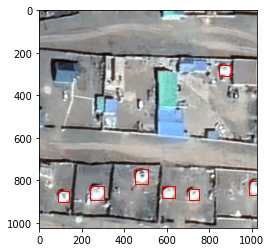

In [8]:
plot_image(0)

In [9]:
def plot_resized_image(resize_size:tuple,value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Resize image
    image = tf.image.resize_with_pad(image,resize_size[0],resize_size[1])
    image = image.astype(np.uint8)

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * resize_size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * resize_size[1]
        width = float(rows['width']) * resize_size[0]
        height = float(rows['height']) * resize_size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

2022-06-04 01:50:13.695288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 01:50:13.696112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 01:50:13.700342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 01:50:13.701170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 01:50:13.701944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

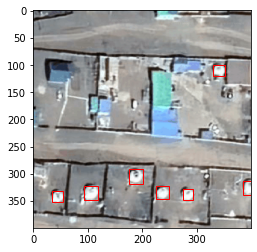

In [10]:
plot_resized_image((400,400),0)

In [11]:
df

,img_name,classes,x,y,width,height
0,kaggle/train/images/04320.png,0,0.981836,0.815967,0.036328,0.067676
1,kaggle/train/images/04320.png,0,0.593945,0.836572,0.059375,0.056152
2,kaggle/train/images/04320.png,0,0.470215,0.762305,0.062695,0.069336
3,kaggle/train/images/04320.png,0,0.264795,0.839844,0.064355,0.066016
4,kaggle/train/images/04320.png,0,0.111328,0.854736,0.051172,0.052832
...,...,...,...,...,...,...
23450,kaggle/train/images/01431.png,0,0.901563,0.052295,0.129297,0.104590
23451,kaggle/train/images/01431.png,0,0.543652,0.027588,0.131445,0.055176
23452,kaggle/train/images/00666.png,0,0.848437,0.108545,0.137109,0.137012
23453,kaggle/train/images/05487.png,0,0.958496,0.692871,0.083008,0.102539


In [12]:
def convert_bbox(x):
    img = Image.open(x['img_name'])
    #sizes = img.size
    # Load xy, width and height
    x_mod = (float(x['x']) - float(x['width']) * 0.5) * img.size[0]
    y_mod = (float(x['y']) - float(x['height']) * 0.5) * img.size[1]
    width_mod = float(x['width']) * img.size[0]
    height_mod = float(x['height']) * img.size[1]
    return pd.Series([x_mod,y_mod,width_mod,height_mod],index=['x_mod','y_mod','width_mod','height_mod'])

In [13]:
df[['x_mod','y_mod','width_mod','height_mod']] = df.apply(lambda x: convert_bbox(x),axis=1)
df[['x_mod','y_mod','width_mod','height_mod']] = df[['x_mod','y_mod','width_mod','height_mod']].astype(int)

In [14]:
df['xmin'] = df['x_mod']
df['xmax'] = df['xmin'] + df['width_mod']
df['ymin'] = df['y_mod']
df['ymax'] = df['ymin'] + df['height_mod']

(-0.5, 1075.225, 1075.225, -0.5)

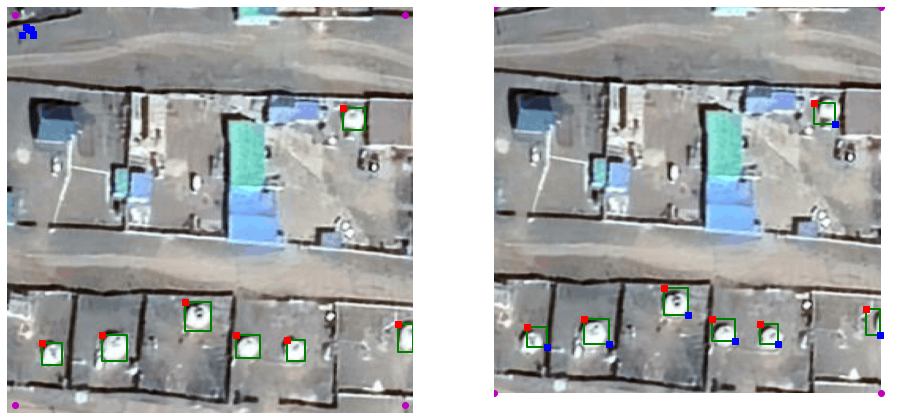

In [15]:

#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 20
tr_y1 = 20
tr_x2 = 20
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['x_mod'],bb_boxes.iloc[i]['y_mod'],
                bb_boxes.iloc[i]['width_mod'],bb_boxes.iloc[i]['height_mod']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['x_mod'] = (bb_boxes['x_mod'] - p1[1])/(p2[1]-p1[1])*img.shape[0]
bb_boxes1['y_mod'] = (bb_boxes['y_mod'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['width_mod'] = (bb_boxes['width_mod'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['height_mod'] = (bb_boxes['height_mod'] - p1[0])/(p3[0]-p1[0])*img.shape[1]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

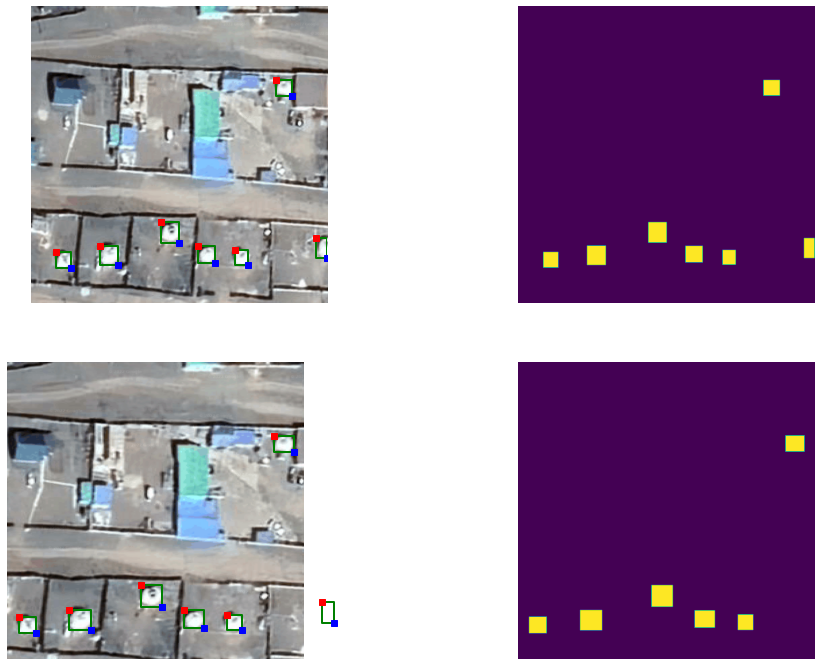

In [16]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

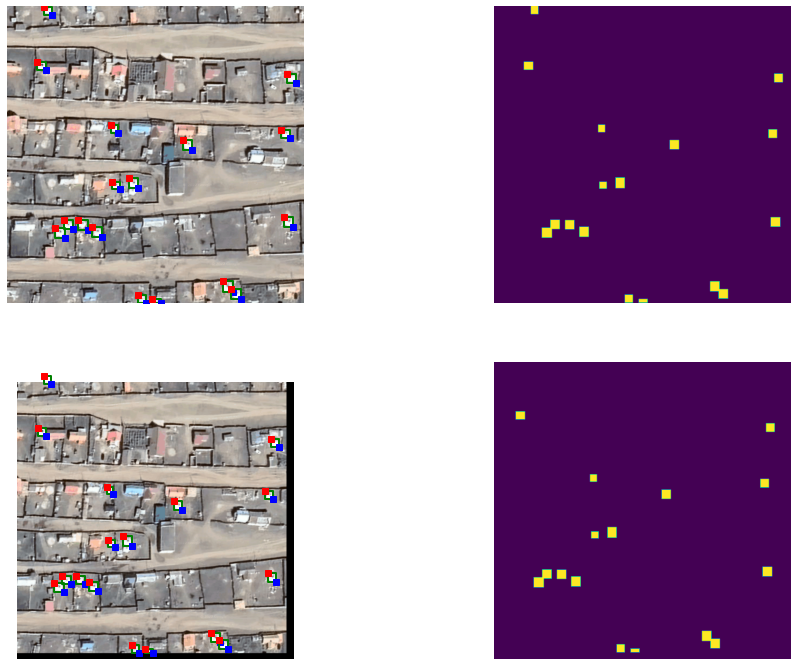

In [17]:
### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(df,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off')

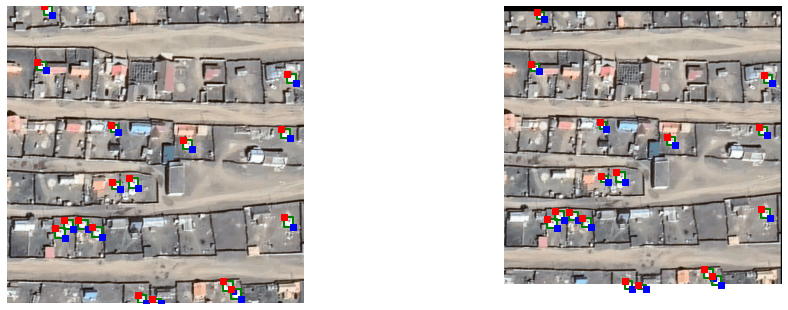

In [18]:
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)

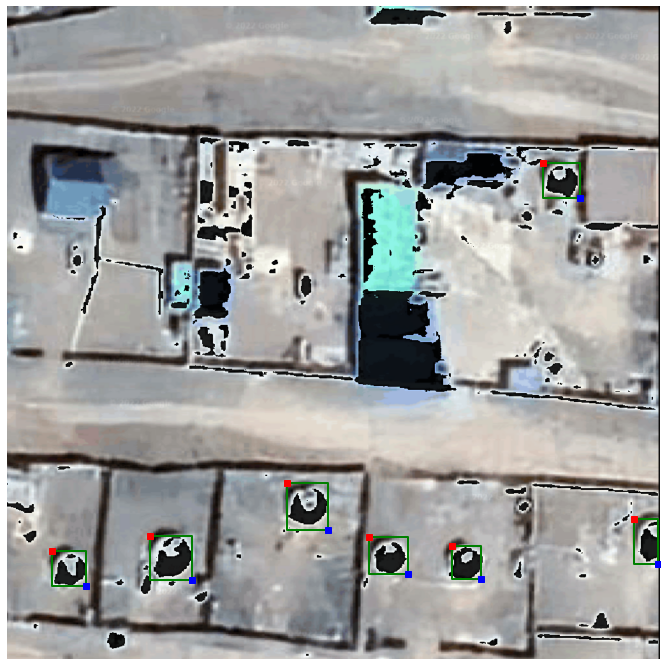

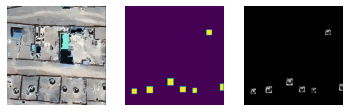

In [19]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(df,1,augmentation=True)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(16,12))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

## Prepare data

In [20]:
##### Testing the generator

training_gen = generate_train_batch(df,10,augmentation=True,img_size=(1024,1024))

In [21]:
batch_img,batch_mask = next(training_gen)

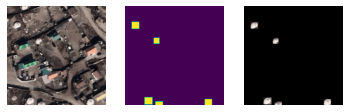

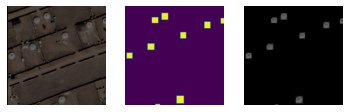

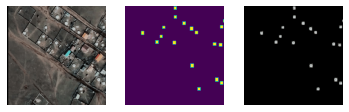

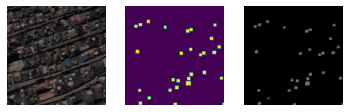

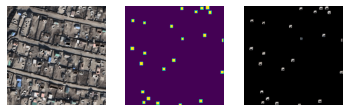

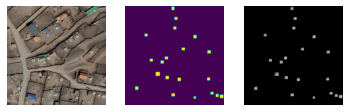

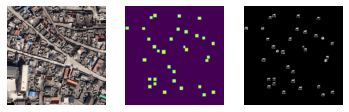

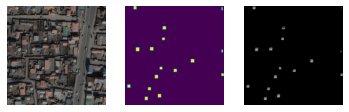

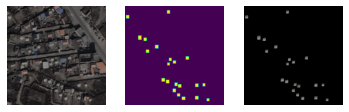

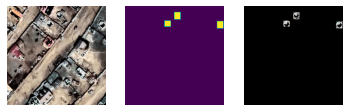

In [22]:
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask))
    plt.axis('off')
    plt.show()

In [23]:
K.set_image_data_format('channels_last')

### Define Model

In [46]:
model_unet = UNet((1024,1024,3))
model_effunet = UXception(None,(512,512,3))
model_swinunet = models.swin_unet_2d((1024, 1024, 3), filter_num_begin=64, n_labels=1, depth=4, stack_num_down=2, stack_num_up=2, 
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512, 
                            output_activation='Sigmoid', shift_window=True, name='swin_unet')

In [47]:
batch_size = 8

In [48]:
model_effunet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 255, 255, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 255, 255, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [49]:
# Train test Split
df['id_mod'] = np.arange(1,len(df) + 1)

In [50]:
val_df = df.sample(frac=0.25)
train_df = df[~df['id_mod'].isin(val_df['id_mod'].values)]

In [51]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [52]:
### Generator 
training_gen = generate_train_batch(train_df,batch_size,augmentation=True,img_size=(512,512))
val_x,val_y = generate_val_batch(val_df,batch_size,augmentation=True,img_size=(512,512))
smooth = 1.
model_effunet.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), 
              loss=bce_dice_loss, metrics=[my_iou_metric])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [53]:
steps_per_epoch = int(len(train_df) / batch_size)

In [54]:
custom_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=int(3),
    min_delta=0.01,
    mode='min',
    restore_best_weights=True
)

In [56]:
history = model_effunet.fit(training_gen,
                            validation_data=val_gen,
                            validation_batch_size=batch_size,
                            steps_per_epoch=steps_per_epoch,
                            epochs=5
                            )

Epoch 1/5
2198/2198 [==============================] - ETA: 0s - loss: 0.8290 - my_iou_metric: 0.0061

KeyboardInterrupt: 

In [32]:
model_unet.save('object_unet_0602.h5')

In [6]:
model_unet = keras.models.load_model('object_unet_0602.h5',
                               compile=False
                               )

2022-06-03 15:32:06.411900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 15:32:06.412723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 15:32:06.418950: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 15:32:06.419740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 15:32:06.420490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [7]:
model_unet.compile(loss=bce_dice_loss,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=[IOU_calc]
              )

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
annot_df = {'img_name' : []}
#sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/test/images/'))):
    ## Empty Labels
    annot_df['img_name'].append(f'kaggle/test/images/{i.split(".")[0]}.png')


3712it [00:00, 1284592.12it/s]


In [22]:
test_df = pd.DataFrame.from_dict(annot_df)

In [23]:
test_gen = generate_test_batch(test_df,8,img_size=(1024,1024))

In [28]:
pred_all[0].shape

(1024, 1024, 1)

In [29]:
batch_img = next(test_gen)
pred_all= model_unet.predict(batch_img)
np.shape(pred_all)

for i in range(4):

    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_img[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


In [23]:
#### Function for drawing bounding boxes, taken from Ryan's code on Udacity

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_list = []
    #print(labels[1])
    if labels[1] > 0:
        for ger_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == ger_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            if ((np.max(nonzeroy)-np.min(nonzeroy)>35) & (np.max(nonzerox)-np.min(nonzerox)>35)):
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                # Draw the box on the image       
                #print(bbox)
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
            else:
                bbox = 0
            bbox_list.append(bbox)
    
    
#except Exception as e:
#    bbox = 0
# Return the image
    return img,bbox_list

def test_new_img(img):
    img = cv2.resize(img,(1024, 1024))
    img = np.reshape(img,(1,1024, 1024,3))
    pred = model_unet.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = im_pred[:,:,0]
    labels = label(heatmap)
    draw_img,labels = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img,labels

In [4]:

test_img = 'kaggle/test/images/06065.png'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,img = test_new_img(im)
img  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]



img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)



#heatmap = im_pred[:,:,0]

#labels = label(heatmap)
# Draw bounding boxes on a copy of the image
#draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
#img_pred = im
#im_pred[:,:,]

draw_img,labels = get_BB_new_img(im)

plt.figure(figsize=(34,28))
plt.subplot(1,3,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img_pred)
plt.title('Segmentation')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off')

NameError: name 'model_unet' is not defined

In [24]:
new_list = []
for i in labels:
    if i != 0:
        new_list.append(i)

### Sample submission

In [8]:
submission = pd.read_csv('kaggle/sample_submission.csv')

In [9]:
submission

,ImageId,EncodedPixels
0,08151.png,102501 20 103525 20 104549 20 105573 20 106597...
1,06064.png,102501 20 103525 20 104549 20 105573 20 106597...
2,06020.png,102501 20 103525 20 104549 20 105573 20 106597...
3,08057.png,102501 20 103525 20 104549 20 105573 20 106597...
4,01639.png,102501 20 103525 20 104549 20 105573 20 106597...
...,...,...
3707,09113.png,102501 20 103525 20 104549 20 105573 20 106597...
3708,00512.png,102501 20 103525 20 104549 20 105573 20 106597...
3709,00857.png,102501 20 103525 20 104549 20 105573 20 106597...
3710,00671.png,102501 20 103525 20 104549 20 105573 20 106597...


In [24]:
def make_bbox(x):
    image_dec = cv2.imread(f'kaggle/test/images/{x}')
    image_dec = np.reshape(image_dec,(1,1024,1024,3))
    preds = model_unet.predict(image_dec)
    img_pred = np.array(255*preds[0],dtype=np.uint8)
    heatmap = img_pred[:,:,0]
    labels = label(heatmap)
    draw_img,labels = draw_labeled_bboxes(np.copy(image_dec), labels)
    return labels

In [25]:
submission['BBoxes'] = submission['ImageId'].apply(lambda x: make_bbox(x))

In [31]:
submission

,ImageId,EncodedPixels,BBoxes
0,08151.png,412028 149 413052 149 414076 149 415100 149 41...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,06064.png,346767 135 347791 135 348815 135 349839 135 35...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,06020.png,266062 164 267086 164 268110 164 269134 164 27...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ((845,..."
3,08057.png,47461 67 48485 67 49509 67 50533 67 51557 67 5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,01639.png,101539 40 102563 40 103587 40 104611 40 105635...,"[((162, 99), (202, 142)), 0, 0, ((485, 151), (..."
...,...,...,...
3707,09113.png,79012 64 80036 64 81060 64 82084 64 83108 64 8...,"[((163, 77), (227, 147)), 0, 0, 0, 0, 0, ((648..."
3708,00512.png,4392 70 5416 70 6440 70 7464 70 8488 70 9512 7...,"[0, 0, 0, 0, 0, 0, ((295, 4), (365, 59)), 0, 0..."
3709,00857.png,21285 36 22309 36 23333 36 24357 36 25381 36 2...,"[0, 0, ((804, 20), (840, 58)), 0, 0, ((593, 59..."
3710,00671.png,70 58 1094 58 2118 58 3142 58 4166 58 5190 58 ...,"[((69, 0), (127, 52)), ((684, 12), (754, 80)),..."


In [32]:
def encodedpixel(x):
    mask = np.zeros((1024,1024))
    for i in x:
        if i == 0:
            continue
        else:
            mask[i[0][1] : i[1][1],i[0][0] : i[1][0]] =1
    
    return mask2rle(mask)





In [28]:
#Encode Pixels
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [29]:
submission['EncodedPixels'] = submission['BBoxes'].apply(lambda x: encodedpixel(x))

In [30]:
submission.query("EncodedPixels != ''")

,ImageId,EncodedPixels,BBoxes
0,08151.png,412028 149 413052 149 414076 149 415100 149 41...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,06064.png,346767 135 347791 135 348815 135 349839 135 35...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,06020.png,266062 164 267086 164 268110 164 269134 164 27...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ((845,..."
3,08057.png,47461 67 48485 67 49509 67 50533 67 51557 67 5...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,01639.png,101539 40 102563 40 103587 40 104611 40 105635...,"[((162, 99), (202, 142)), 0, 0, ((485, 151), (..."
...,...,...,...
3707,09113.png,79012 64 80036 64 81060 64 82084 64 83108 64 8...,"[((163, 77), (227, 147)), 0, 0, 0, 0, 0, ((648..."
3708,00512.png,4392 70 5416 70 6440 70 7464 70 8488 70 9512 7...,"[0, 0, 0, 0, 0, 0, ((295, 4), (365, 59)), 0, 0..."
3709,00857.png,21285 36 22309 36 23333 36 24357 36 25381 36 2...,"[0, 0, ((804, 20), (840, 58)), 0, 0, ((593, 59..."
3710,00671.png,70 58 1094 58 2118 58 3142 58 4166 58 5190 58 ...,"[((69, 0), (127, 52)), ((684, 12), (754, 80)),..."


In [33]:
submission[['ImageId','EncodedPixels']].to_csv('submission_third.csv',index=False)

In [97]:
#Encode Pixels
def mask2rle(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

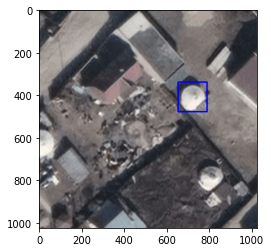

In [50]:

plt.imshow(cv2.rectangle(im,labels[6][1],labels[6][0],(0,0,255),6))

In [39]:
labels[6]

((653, 338), (789, 477))

In [30]:
mask2rle(im_pred)

ValueError: operands could not be broadcast together with shapes (4222,) (4223,) (4222,) 

In [374]:
pixels = np.concatenate([[0],pixels,[0]])

In [379]:
runs = np.where(pixels[1:]!=pixels[:-1])[0]

In [380]:
len(runs[1::2])

4222

In [381]:
len(runs[::2])

4223

In [382]:
mask2rle(im_pred)

ValueError: operands could not be broadcast together with shapes (4222,) (4223,) (4222,) 